In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# データセットの準備
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # MNISTの画像を[-1, 1]に正規化
])

train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)


In [2]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 28*28),
            nn.Tanh()
        )
    
    def forward(self, x):
        return self.model(x).view(-1, 1, 28, 28)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(28*28, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        x = x.view(-1, 28*28)
        return self.model(x)

# モデルのインスタンス化
generator = Generator()
discriminator = Discriminator()


In [3]:
# 最適化アルゴリズム
optim_g = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optim_d = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# 損失関数
criterion = nn.BCELoss()

In [6]:
# 訓練
num_epochs = 10 # 50
for epoch in range(num_epochs):
    for real_images, _ in train_loader:
        batch_size = real_images.size(0)

        # リアル画像のラベルを1、偽画像のラベルを0とする
        real_labels = torch.ones(batch_size, 1)
        fake_labels = torch.zeros(batch_size, 1)

        # 識別器の訓練
        discriminator.zero_grad()
        outputs = discriminator(real_images)
        loss_d_real = criterion(outputs, real_labels)
        loss_d_real.backward()

        # 偽画像を生成して識別
        z = torch.randn(batch_size, 100)
        fake_images = generator(z)
        outputs = discriminator(fake_images.detach())  # 勾配がGに流れないようにdetach()を使う
        loss_d_fake = criterion(outputs, fake_labels)
        loss_d_fake.backward()
        optim_d.step()

        # 生成器の訓練
        generator.zero_grad()
        outputs = discriminator(fake_images)
        loss_g = criterion(outputs, real_labels)  # GがDを騙せたと考える
        loss_g.backward()
        optim_g.step()

    print(f'Epoch [{epoch+1}/{num_epochs}] Loss D: {loss_d_real.item() + loss_d_fake.item()}, Loss G: {loss_g.item()}')


Epoch [1/10] Loss D: 0.46650925278663635, Loss G: 1.879603385925293
Epoch [2/10] Loss D: 0.5624747946858406, Loss G: 4.19631814956665
Epoch [3/10] Loss D: 0.2733967751264572, Loss G: 3.3724842071533203
Epoch [4/10] Loss D: 0.507138803601265, Loss G: 2.3587758541107178
Epoch [5/10] Loss D: 0.30923371762037277, Loss G: 2.990514039993286
Epoch [6/10] Loss D: 0.9279255215078592, Loss G: 2.976959228515625
Epoch [7/10] Loss D: 0.3426602631807327, Loss G: 2.7168636322021484
Epoch [8/10] Loss D: 0.5403139442205429, Loss G: 1.8974099159240723
Epoch [9/10] Loss D: 0.5289479345083237, Loss G: 1.9294023513793945
Epoch [10/10] Loss D: 0.8386924564838409, Loss G: 1.82965087890625


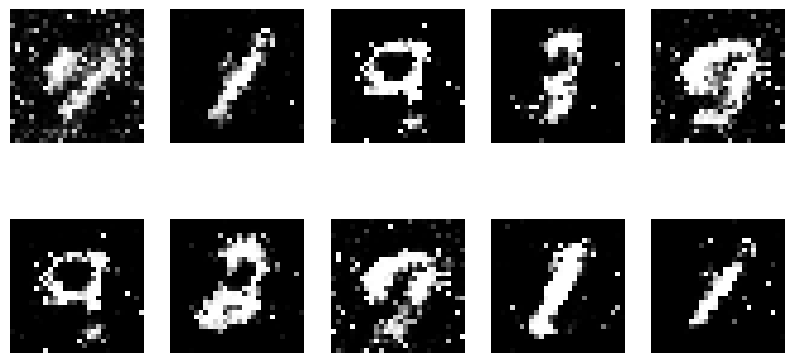

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# 生成器から画像を生成
def generate_images(generator, num_images=10):
    # 生成器の評価モードをオン
    generator.eval()

    # 標準正規分布からランダムノイズを生成
    z = torch.randn(num_images, 100)

    # 生成器で画像を生成
    with torch.no_grad():  # 勾配計算を無効化
        fake_images = generator(z).cpu().view(-1, 28, 28)

    return fake_images

# 生成された画像を表示
def show_images(images):
    plt.figure(figsize=(10, 5))
    for i, image in enumerate(images):
        plt.subplot(2, 5, i + 1)
        plt.imshow(image, cmap='gray')
        plt.axis('off')
    plt.show()

# 画像生成
fake_images = generate_images(generator, num_images=10)
show_images(fake_images)
